
Based on NLP From Scratch: Generating Names with a Character-Level RNN
*************************************************************
by: `Sean Robertson <https://github.com/spro/practical-pytorch>`_


In [21]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math
from random import shuffle
import torch
import torch.nn as nn
from functools import reduce
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

%matplotlib inline

# RNN/LSTM Classes

In [62]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bias=True, batch_first=False,
                dropout=0, bidirectional=False):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, bias=bias, batch_first=batch_first,
                           dropout=dropout, bidirectional=bidirectional)

        self.o2o = nn.Linear(self.num_directions * hidden_size, output_size)
    def forward(self, my_input, hidden):
        output, hidden = self.lstm(my_input, hidden)
        output = self.o2o(output)
        return output, hidden

    def initHidden(self, batch=1, device=torch.device('cpu')):
        return (torch.zeros(self.num_layers,1,self.hidden_size, device=device), torch.zeros(self.num_layers * self.num_directions,batch,self.hidden_size,device=device))

    
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bias=True, batch_first=False,
                dropout=0, bidirectional=False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, bias=bias, batch_first=batch_first,
                           dropout=dropout, bidirectional=bidirectional)

        self.o2o = nn.Linear(self.num_directions * hidden_size, output_size)
    def forward(self, my_input, hidden):
        output, hidden = self.rnn(my_input, hidden)
        output = self.o2o(output)
        return output, hidden

    def initHidden(self, batch=1, device=torch.device('cpu')):
        return torch.zeros(self.num_layers,1,self.hidden_size, device=device)


# Helper Functions

In [47]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def string_to_chars(original):
    raw_lines = original.splitlines()

    def proc_line(l): return [l] if l == '<start>' or l == '<end>' else list(l)
    chars = reduce(lambda x, y : x + ['\n'] + y, list(map(proc_line, raw_lines)))
    assert original == ''.join(chars)
    return chars

def make_encoder(raw):
    chars = string_to_chars(raw)
    decoder = [c for c in Counter(chars)]
    decoder = sorted(decoder)
    return {c:i for i, c in enumerate(decoder)}, decoder

def split_songs(raw):
    return re.findall('(<start>.*?<end>)',raw,flags=re.DOTALL)

def song_to_tensor_chunks(song, encoder, decoder):
    training_chunks = []
    target_chunks = []
    for i in range(0,len(song),100):
        start = i
        if start+100 > len(song) - 1:
            end = len(song)
            target_range = list(np.arange(start + 1, end,dtype=np.int)) + [int(end - 1)]
        else:
            end = start + 100
            target_range = np.arange(start+1, end+1, dtype=np.int)
        chunk = torch.zeros(end-start, 1, n_chars)
        for i, c in enumerate(song[start:end]):
            chunk[i,0,encoder[c]] = 1
        target_chunk = []
        for i in target_range:
            target_chunk.append(encoder[song[i]])
        target_chunks.append(torch.tensor(target_chunk))
        training_chunks.append(chunk)
    return training_chunks, target_chunks

def heatmap_activations(net, seq_len, temperature):
    torch.manual_seed(777)  # reproducibility
    with torch.no_grad():
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = net.initHidden(device=device)
        h, _ = hidden
        activations = []
        output = ['<start>']
        prev_char_raw, hidden = net(input_tensor,hidden) 
        prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        for i in range(seq_len):
            output_dist = prev_char_raw.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            selected_char = decoder[top_i.item()]
            output.append(selected_char)
            input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
            input_tensor = input_tensor_chunk[0].to(device)
            h_i, _ = hidden
            activations.append(h_i.squeeze())
            if selected_char == '<end>':
                selected_char = '<start>'
                input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
                input_tensor = input_tensor_chunk[0].to(device)
                hidden = net.initHidden(device=device)
            prev_char_raw, hidden = net(input_tensor,hidden)
            prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        return output[:-1], activations
    
def neural_activations(activations, i): return list(map(lambda x:x[i].item(), activations))
def make_heatmap_for_neuron(neuron, activations,inputs,shape=(20,30)):
    title = f"Heatmap of neuron: {neuron}"
    xlabel= ""
    ylabel=""
    data = np.array(neural_activations(activations,neuron)).reshape(shape)


    plt.figure(figsize=(20, 10))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    c = plt.pcolor(data, edgecolors='k', linewidths=4, cmap='seismic', vmin=0.0, vmax=1.0)

    def show_values(pc, labels):
        pc.update_scalarmappable()
        ax = pc.axes
        #print(pc.get_array())
        for p, color, value, label in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array(),labels):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, label, ha="center", va="center", color=color)

    show_values(c,inputs)

    plt.colorbar(c)
    plt.savefig(f"heatmaps/Heatmap_{neuron}")
    plt.close()

# Training Functions



In [4]:
def train(net, song, criterion, optimizer=None, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = net.initHidden(device=device)
    net.zero_grad()

    loss = 0

    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        for i in range(input_line_tensor.size(0)):
            output, hidden = net(input_line_tensor[i].view((1,1,n_chars)).to(device), hidden)
    #         print(output)
            l = criterion(output.view((1,n_chars)), target_line_tensor[i].to(device))
            loss += l / input_line_tensor.size(0)
    loss.backward()
    optimizer.step()
    return output, loss.item() / len(train_chunks)

def test(net, song, criterion, device=torch.device('cpu')):
    train_chunks, target_chunks = song_to_tensor_chunks(song, encoder,decoder)
    hidden = net.initHidden(device=device)
    loss = 0
    for input_line_tensor, target_line_tensor in zip(train_chunks,target_chunks):
        target_line_tensor.unsqueeze_(-1)
        output, hidden = net(input_line_tensor.to(device), hidden)
        seq_len,_ = target_line_tensor.size()
        l = criterion(output.view((seq_len,n_chars)), target_line_tensor.view((seq_len)).to(device))
        loss += l
    return output, loss.item() / len(train_chunks)

In [39]:
# Generates song using temperature of samples
def sample_temp(temperature = 0.8):
    with torch.no_grad():
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = net.initHidden(device=device)
        prev_char_raw, hidden = net(input_tensor,hidden) 
        prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        output = '<start>'
        while True:
            output_dist = prev_char_raw.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]
            selected_char = decoder[top_i.item()]
            output += selected_char
            input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
            input_tensor = input_tensor_chunk[0].to(device)
            # End song 
            if selected_char == '<end>':
                break
            # Get next letter 
            else:
                prev_char_raw, hidden = net(input_tensor,hidden) 
                prev_char_probs = torch.softmax(prev_char_raw, 2, prev_char_raw.dtype).view((n_chars))
        return output

In [53]:
def sample_max(max_length = 1000):
    with torch.no_grad():
        counter = 0
        input_tensor_chunk, _ = song_to_tensor_chunks(['<start>'], encoder, decoder)
        input_tensor = input_tensor_chunk[0].to(device)
        hidden = net.initHidden(device=device)
        prev_char_raw, hidden = net(input_tensor,hidden) 
        output = '<start>'
        maxarg = torch.argmax(prev_char_raw)
        while True:
            selected_char = decoder[maxarg.item()]
            #print('selected_char', selected_char)
            output += selected_char
            input_tensor_chunk, _ = song_to_tensor_chunks([selected_char], encoder, decoder)
            input_tensor = input_tensor_chunk[0].to(device)
            # End of song
            if selected_char == '<end>':
                break
            # Song is repeating and wont end
            if counter == max_length:
                output += '<end>'
                break
            else:
                prev_char_raw, hidden = net(input_tensor,hidden) 
                maxarg = torch.argmax(prev_char_raw)
            counter += 1
        return output

In [7]:
# Check if your system supports CUDA
use_cuda = torch.cuda.is_available()

# Setup GPU optimization if CUDA is supported
if use_cuda:
    device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

CUDA is supported


In [9]:
def run(net_type, n_epochs = 25, hidden_size = 100):
    learning_rate = 0.05
    n_iters = 10000
    print_every = 80
    plot_every = 10
    train_loss = []
    val_loss = []
    total_loss = 0 # Reset every plot_every iters    

    start = time.time()

    # Setting network params 
    # Decides if network is either RNN or LSTM
    if (net_type == 'RNN'):
        net = RNN(n_chars, hidden_size, n_chars).to(device) #hidden_size originally 128
    else:
        net = LSTM(n_chars, hidden_size, n_chars).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    #rnn.load_state_dict(torch.load('rnn_1574760411.pt'))
    #rnn = rnn.to(device)
    #train_loss = list(map(float,(open('train_loss_1574760411.csv').read().splitlines())))
    #val_loss = list(map(float,(open('val_loss_1574760411.csv').read().splitlines())))
    #print(len(train_loss))
    #start = len(train_loss)

    for epoch in range(1, n_epochs+1):
        shuffle(train_songs)
        total_loss = 0
        for i, song in enumerate(train_songs):
            output, loss = train(net, song, criterion, optimizer=optimizer, device=device)
            total_loss += loss
            if i % print_every == 0:
                print('%s (%d %d%%) %.4f' % (timeSince(start), i, i / len(train_songs) * 100, loss))

        # getting validation loss 
        train_loss.append(total_loss / len(train_songs))
        with torch.no_grad():
            total_loss = 0
            for song in test_songs:
                _, loss = test(net, song, criterion, device=device)
                total_loss += loss
            val_loss.append(total_loss / len(test_songs))
        
        # Save network settings
        torch.save(net.state_dict(),f'rnn_{net_type}_{hidden_size}_{epoch}.pt')
        with open(f'train_loss_{net_type}_{hidden_size}_{epoch}.csv', 'w+') as out:
            out.write('\n'.join(map(str,train_loss)))

        with open(f'val_loss_{net_type}_{hidden_size}_{epoch}.csv', 'w+') as out:
            out.write('\n'.join(map(str,val_loss)))
        print('Epoch %d %s val loss: %.4f train loss: %.4f\n' % (epoch,timeSince(start), val_loss[-1], train_loss[-1]))   
    return net, train_loss, val_loss

In [49]:
def plotting(train_loss, val_loss):
# Plotting loss and validation 
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker
    offset = 0
    epoch_nums = [i for i in range(len(train_loss)+1)]
    print('Train Loss: ', train_loss)
    print('Validation Loss: ', val_loss)
    with open('train_loss_{offset}.csv', 'w+') as out:
        out.write('\n'.join(map(str,train_loss)))

    with open('val_loss_{offset}.csv', 'w+') as out:
        out.write('\n'.join(map(str,val_loss)))
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.show()

In [8]:
# Creating data
raw_train = open('train.txt').read()
train_songs = list(map(string_to_chars, split_songs(raw_train)))

reconstructed = '\n'.join(map(''.join, train_songs))
encoder, decoder = make_encoder(raw_train)
n_chars = len(decoder)

val_songs = list(map(string_to_chars, split_songs(open('val.txt').read())))
test_songs = list(map(string_to_chars, split_songs(open('test.txt').read())))
assert reconstructed == raw_train


# Part a/b) 

0m 3s (0 0%) 4.5654
0m 38s (80 9%) 3.5055
1m 9s (160 19%) 3.6344
1m 37s (240 29%) 3.5255
2m 9s (320 39%) 3.2424
2m 35s (400 49%) 3.0195
3m 5s (480 59%) 3.2078
3m 38s (560 69%) 2.7893
4m 11s (640 79%) 3.0374
4m 42s (720 89%) 3.1494
5m 13s (800 99%) 2.8662
Epoch 1 5m 15s val loss: 2.6185 train loss: 3.2350

5m 16s (0 0%) 2.8671
5m 48s (80 9%) 2.7215
6m 20s (160 19%) 2.5152
6m 50s (240 29%) 2.5515
7m 19s (320 39%) 2.6282
7m 52s (400 49%) 2.7056
8m 29s (480 59%) 2.5407
9m 2s (560 69%) 2.6336
9m 32s (640 79%) 2.0865
10m 4s (720 89%) 2.2084
10m 33s (800 99%) 2.2221
Epoch 2 10m 36s val loss: 2.2742 train loss: 2.5187

10m 36s (0 0%) 2.3819
11m 10s (80 9%) 2.1640
11m 41s (160 19%) 2.0061
12m 15s (240 29%) 2.1233
12m 47s (320 39%) 2.3703
13m 18s (400 49%) 2.7332
13m 47s (480 59%) 1.8616
14m 20s (560 69%) 2.0716
14m 50s (640 79%) 2.1879
15m 17s (720 89%) 2.1491
15m 46s (800 99%) 2.0691
Epoch 3 15m 49s val loss: 2.0986 train loss: 2.1935

15m 49s (0 0%) 2.3875
16m 18s (80 9%) 2.0025
16m 54s (160 

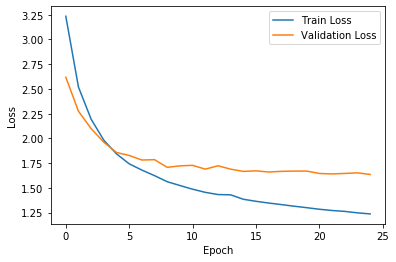

In [11]:
torch.manual_seed(777)  # reproducibility
# Run LSTM, 25 epochs, hidden size 100
net, train_loss, val_loss = run('LSTM', 25, 100)
# plot losses
plotting(train_loss, val_loss)

In [57]:
torch.manual_seed(777)  # reproducibility
# Printing 6 songs at temperatures = 1, 2, 0.5
# printing two samples with temp = 1
for i in range(2):
    print('T = 1, Song ', i+1)
    print(sample_temp(1))
    print('\n')

# printing two samples with temp = 2
for i in range(2):
    print('T = 2, Song ', i+1)
    print(sample_temp(2))
    print('\n')

# printing two samples with temp = 0.5
for i in range(2):
    print('T = 0.5, Song ', i+1)
    print(sample_temp(0.5))
    print('\n')

T = 1, Song  1
<start>
X:3
T:Cedmase's O'Foigne
R:jig
H:Ma daul of Challeary
I:abc3
H:A lardithephe Arin.
Z:id:hn-jig-30
M:6/8
K:A
EFE GBde|~f3 bag|afe dfe|faf fed|fad fef|~g3 gde|fdc ced|BGA B2E|
Bdd dEG|gfe ded|d2e fdB|A2e gaf|f2e dBG|FEE E2B|FDE EEF|
GBF GFd|~B3 ~B3|dcB ^GE|EDF AFD|B2c B2G|
Bde fdg|fed edB|Adc dBG|AGA BED|1 DED E2E||
W:fardipare =C. deaastid ce renta!cilc, ve figfsc atr be scorsus ? ri?has ?ra-li moi oo-ro?
En vuz | ce lol's J'ance pa-te? !
W:Arod ((c=_)
F2z4G | A4 c4 | EFAc dBAB| dcdc c2A2 | A6 ||
E^AB d2d2 | c2A2B2 | F4 | (E3)B,2 | 
(e2d) (3)ue | d2z2 | (dele) | (3Be)g | (e2)g g)f | ('abg) g2d | (e2)e2g2 | e2B2 (3(3GE) | (3BGA (3BAd (3(GG) (3(g/ef) | g2e2 |
ffgff | dgfe | df4e | d2efe | d3f | g^edB | c Bcd | BcdB |1 A4 :|
<end>


T = 1, Song  2
<start>
X:23
T:Blaush Finve
O:France
A:Provance
C:SlatsAtte.thespoule The
D:Dess whil\'Ginttes of Cillte'schey
C:Friew Sinntre, The Crapliny dormip ton parise Fa herd, Fri?cratte
Z:<erinot obs oblonainomoile: Hargallale@le@

# Part c) 

0m 0s (0 0%) 4.5793
0m 30s (80 9%) 3.7464
1m 1s (160 19%) 3.5526
1m 32s (240 29%) 3.6623
2m 4s (320 39%) 3.4536
2m 33s (400 49%) 3.5101
2m 59s (480 59%) 3.1425
3m 24s (560 69%) 3.0177
3m 55s (640 79%) 3.1405
4m 25s (720 89%) 2.7977
4m 50s (800 99%) 2.7743
Epoch 1 4m 52s val loss: 2.9115 train loss: 3.4163

4m 52s (0 0%) 2.9927
5m 19s (80 9%) 3.0318
5m 54s (160 19%) 3.1110
6m 23s (240 29%) 2.8177
6m 52s (320 39%) 2.6944
7m 17s (400 49%) 2.4926
7m 42s (480 59%) 2.8051
8m 11s (560 69%) 2.9674
8m 39s (640 79%) 2.7756
9m 9s (720 89%) 2.7226
9m 34s (800 99%) 3.5032
Epoch 2 9m 36s val loss: 2.5077 train loss: 2.7960

9m 37s (0 0%) 2.6212
10m 6s (80 9%) 2.6859
10m 33s (160 19%) 2.5364
10m 59s (240 29%) 2.6875
11m 27s (320 39%) 2.4044
11m 55s (400 49%) 2.5403
12m 22s (480 59%) 2.5780
12m 54s (560 69%) 2.2469
13m 19s (640 79%) 2.4199
13m 47s (720 89%) 2.3103
14m 17s (800 99%) 2.3816
Epoch 3 14m 20s val loss: 2.3023 train loss: 2.4864

14m 20s (0 0%) 2.5953
14m 47s (80 9%) 2.2875
15m 13s (160 19%

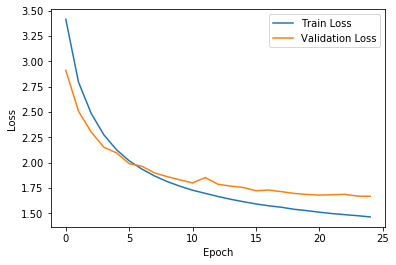

In [58]:
# Running LSTM with different hidden sizes 

torch.manual_seed(777)  # reproducibility
# Run LSTM, 25 epochs, hidden size 50
net_50, train_loss_50, val_loss_50 = run('LSTM', 25, 50)
# plot losses
plotting(train_loss_50, val_loss_50)

0m 0s (0 0%) 4.5639
0m 31s (80 9%) 3.3462
0m 59s (160 19%) 3.4383
1m 29s (240 29%) 3.2826
1m 58s (320 39%) 3.7258
2m 24s (400 49%) 3.1368
2m 51s (480 59%) 3.2311
3m 19s (560 69%) 3.2424
3m 46s (640 79%) 2.6975
4m 12s (720 89%) 2.9493
4m 39s (800 99%) 2.6413
Epoch 1 4m 41s val loss: 2.7931 train loss: 3.3250

4m 42s (0 0%) 2.9687
5m 8s (80 9%) 2.8269
5m 33s (160 19%) 2.6625
5m 58s (240 29%) 2.6739
6m 24s (320 39%) 2.7300
6m 55s (400 49%) 2.2812
7m 23s (480 59%) 2.5187
7m 52s (560 69%) 2.1581
8m 18s (640 79%) 2.6566
8m 47s (720 89%) 2.5233
9m 15s (800 99%) 2.7012
Epoch 2 9m 18s val loss: 2.3974 train loss: 2.6656

9m 18s (0 0%) 2.2292
9m 46s (80 9%) 2.4307
10m 14s (160 19%) 2.3120
10m 42s (240 29%) 2.3138
11m 8s (320 39%) 2.2159
11m 38s (400 49%) 2.3082
12m 11s (480 59%) 3.2368
12m 38s (560 69%) 1.9707
13m 4s (640 79%) 2.2271
13m 30s (720 89%) 2.2998
13m 56s (800 99%) 1.9733
Epoch 3 13m 59s val loss: 2.1497 train loss: 2.3165

14m 0s (0 0%) 2.1315
14m 27s (80 9%) 2.1660
14m 57s (160 19%)

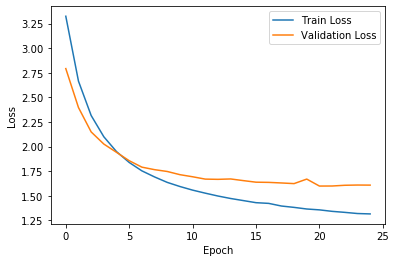

In [59]:
torch.manual_seed(777)  # reproducibility
# Run LSTM, 25 epochs, hidden size 75
net_75, train_loss_75, val_loss_75 = run('LSTM', 25, 75)
# plot losses
plotting(train_loss_75, val_loss_75)

0m 0s (0 0%) 4.5394
0m 25s (80 9%) 3.6843
0m 56s (160 19%) 3.5858
1m 27s (240 29%) 3.5220
1m 57s (320 39%) 3.2483
2m 24s (400 49%) 3.0208
2m 53s (480 59%) 3.2784
3m 23s (560 69%) 2.7365
3m 48s (640 79%) 2.7012
4m 16s (720 89%) 2.5831
4m 42s (800 99%) 3.4614
Epoch 1 4m 45s val loss: 2.4876 train loss: 3.1686

4m 45s (0 0%) 2.7040
5m 11s (80 9%) 2.5492
5m 43s (160 19%) 2.3968
6m 10s (240 29%) 2.3746
6m 39s (320 39%) 2.3721
7m 7s (400 49%) 2.7552
7m 34s (480 59%) 1.9885
8m 3s (560 69%) 2.0539
8m 29s (640 79%) 1.7805
8m 54s (720 89%) 2.3003
9m 25s (800 99%) 2.0351
Epoch 2 9m 28s val loss: 2.2063 train loss: 2.3669

9m 28s (0 0%) 2.0719
9m 58s (80 9%) 1.9278
10m 26s (160 19%) 1.9098
10m 58s (240 29%) 2.1136
11m 22s (320 39%) 2.1964
11m 47s (400 49%) 1.9970
12m 14s (480 59%) 1.9908
12m 36s (560 69%) 1.8688
13m 6s (640 79%) 1.7752
13m 36s (720 89%) 1.7013
14m 7s (800 99%) 1.9511
Epoch 3 14m 11s val loss: 2.0181 train loss: 2.0448

14m 11s (0 0%) 1.8732
14m 40s (80 9%) 1.1509
15m 10s (160 19%)

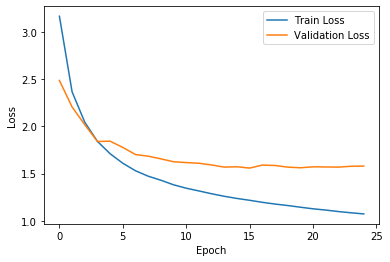

In [60]:
torch.manual_seed(777)  # reproducibility
# Run LSTM, 25 epochs, hidden size 150
net_150, train_loss_150, val_loss_150 = run('LSTM', 25, 150)
# plot losses
plotting(train_loss_150, val_loss_150)

# Part d)

In [50]:
torch.manual_seed(777)  # reproducibility
# Generating music with temperature = 0.7 sampling
print(sample_temp(0.7))

<start>
X:2
T:Biglet Carlect Conne
R:Bourre
R:Scattso
D:Orine Bour Manth afros: The Barris
Z:id:hn-jig-4
M:6/8
K:Edor
EFG FAF|FED DEF|EFE ecB|ABG FED|DED EFE|DEE E3|
EED FEF|E2E ABd|cde fed|fed efg|e2e fed|1 fde ded||
<end>


In [54]:
torch.manual_seed(777)  # reproducibility
# Generating music with max output sampling
print(sample_max())

<start>
X:1
T:La couro
O:France
A:Provence
C:Trad.
R:Marche
Z:Transcrit et/ou corrig? par Michel BELLON - 2005-07-23
Z:Pour toute observation mailto:galouvielle@free.fr
M:2/4
L:1/8
K:Bb
V:1
c2c2c2|c2c2 | c2c2 | c2c2 | c2c2 | c2c2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 | B2B2 

# Part e) 

In [ ]:
# Using RNN instead of LSTM 
torch.manual_seed(777)  # reproducibility
# Run RNN, 25 epochs, hidden size 100
net_rnn, train_loss_rnn, val_loss_rnn = run('RNN', 25, 100)
# plot losses
plotting(train_loss_rnn, val_loss_rnn)

0m 0s (0 0%) 4.5429
0m 25s (80 9%) 3.6267
0m 52s (160 19%) 3.6814
1m 19s (240 29%) 3.4367
1m 46s (320 39%) 3.0809
2m 15s (400 49%) 2.9570
2m 47s (480 59%) 3.0153
3m 17s (560 69%) 2.8508
3m 41s (640 79%) 2.5706
4m 9s (720 89%) 2.6440
4m 33s (800 99%) 2.4824
Epoch 1 4m 36s val loss: 2.4900 train loss: 3.0995

4m 36s (0 0%) 2.8837
5m 4s (80 9%) 2.5299
5m 26s (160 19%) 2.2926
5m 53s (240 29%) 2.5932
6m 22s (320 39%) 2.8734
6m 52s (400 49%) 2.3101
7m 18s (480 59%) 2.1537
7m 47s (560 69%) 2.6957
8m 14s (640 79%) 2.1384
8m 42s (720 89%) 2.5039
9m 13s (800 99%) 2.1465
Epoch 2 9m 15s val loss: 2.2702 train loss: 2.3857

9m 16s (0 0%) 2.0848
9m 42s (80 9%) 2.2027
10m 11s (160 19%) 1.9461
10m 43s (240 29%) 1.6842
11m 10s (320 39%) 2.0691
11m 35s (400 49%) 1.9915
12m 3s (480 59%) 2.0791
12m 34s (560 69%) 2.0807
13m 4s (640 79%) 2.2233
13m 35s (720 89%) 1.9981
14m 3s (800 99%) 1.8434
Epoch 3 14m 5s val loss: 2.1083 train loss: 2.1480

14m 5s (0 0%) 2.0777
14m 33s (80 9%) 2.1008
15m 8s (160 19%) 2.0

# Part f) 

In [48]:
# Heatmaps 
torch.manual_seed(777)
inputs, activations = heatmap_activations(net, 600, 0.5)
inputs = '<FOOBAR>'.join(inputs).replace('\n','\\n').replace(' ','sp').split('<FOOBAR>')

for i in range(100):
    make_heatmap_for_neuron(i, activations, inputs)